In [83]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob
import yaml

In [2]:
def get_inverse_pespective(perspective_matrix: np.array)-> np.array:
  """
  This method calculates the inverse of prespective matrix by homography. 
  - Takes 4 random points on the floor plane(destination_plane) and calculates the corresponding points 
  on the camera image plane(src_plane) using perspective matrix.
  - Calculates the Homography matrix to map any point in image plane to floor plane.
  Parameters
  ----------
  perspective_matrix: 3 x 4 camera prespective matrix to convert 3d homogeneous world coordinates to 
  2d homogeneous camera coordinates.
  Returns
  ----------
  3x3 homography matrix for moving from 2d homogeneous image plane to world floor plane(at z=0)
  
  """
  #Take 5 homogenous points on the floor(Unit is in Meters)
  pts_dst = np.array([[0,0,0,1],
                      [0,1,0,1],
                      [1,0,0,1],
                      [1,1,0,1],
                      [0,0,0,1]
                    ])
  #Obtain respective homogenous points on the image plane
  pts_src = (perspective_matrix @ pts_dst.T).T
  
  #convert homogenous coordinates to cartesian coorndinates
  pts_src_cart = np.array([[x/w, y/w] for x,y,w in pts_src])
  pts_dst_cart = np.array([[x/w, y/w] for x,y,z,w in pts_dst])
  
  #find the 3x3 Homography Matrix for transforming image plane to floor plane
  H, status = cv2.findHomography(pts_src_cart, pts_dst_cart)
  return H
  
def project_to_floor(image_coordinates, H: np.array): 
  """
  This method takes the Homography matrix and the 2d image cartesian coordinates. It returns the (x, y)
  cartesian coordinates in 3d cartesian world coordinates on floor plane(at z=0). Notice that z coordinate is omitted
  here and added inside the tracking funtion. 
  
  Parameters
  ----------
  image_coordinates: 2d pixel coordinates (x,y)
  h: 3x3 Homography matrix np.array[3x3]
  Returns
  ----------
  floor_coordinates: List of x, y coordinates in 3d world of same pixel on floor plane i.e. (x,y,z) Considering z=0 and 
  ommitted here.
  """
  #adding 1 for homogenous coordinate system
  x, y, w = H @ np.array([[*image_coordinates, 1]]).T
  return [x/w, y/w]

p = np.random.rand(3,4)
H = get_inverse_pespective(p)
src_point = (5,10)
dst_point = project_to_floor(src_point, H)

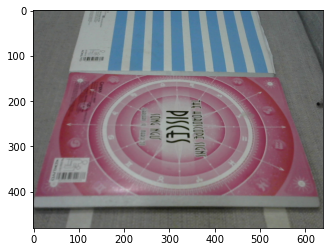

In [7]:
img = cv.imread('rectification.png')
plt.imshow(img)

Text(0.5, 1.0, 'Upper right')

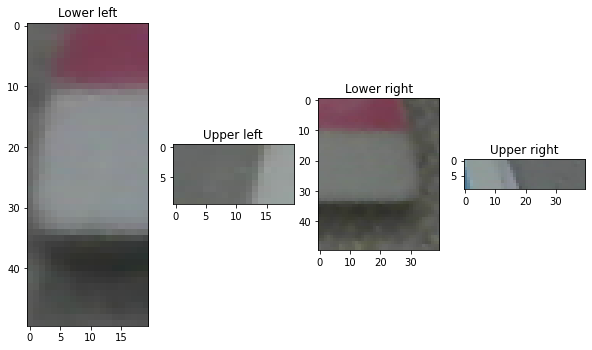

In [65]:
# Finding corners manually
plt.figure(figsize=(10,10))
plt.subplot(141); plt.imshow(img[400: 450, 0: 20]); plt.title('Lower left')
plt.subplot(142); plt.imshow(img[0:10, 100:120]); plt.title('Upper left')
plt.subplot(143); plt.imshow(img[400: 450, 600: 640]); plt.title('Lower right')
plt.subplot(144); plt.imshow(img[0:10, 480:520]); plt.title('Upper right')

Text(0.5, 1.0, 'Transformed')

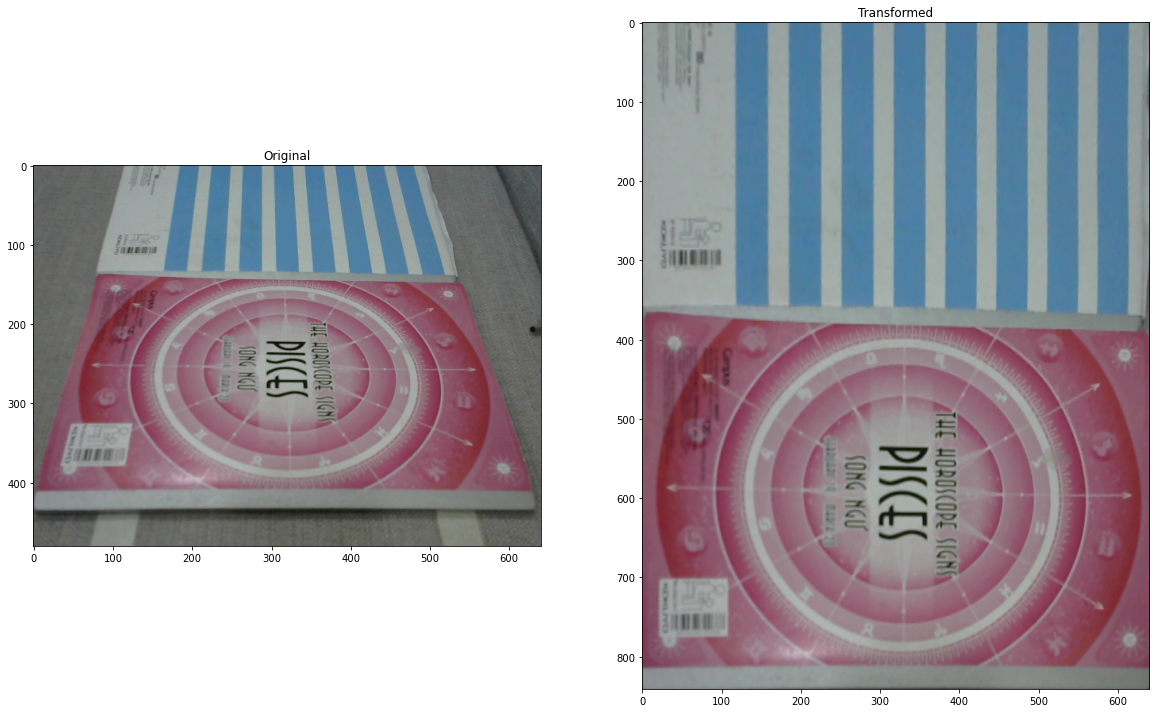

In [102]:
FRAME_WIDTH = 640
FRAME_HEIGHT = 480

object_width, object_height = 25.1, 33

# Define corner from manual inspection
lower_left_corner = [0, 433]
upper_left_corner = [115, 0]
lower_right_corner = [633, 433]
upper_right_corner = [495, 0]
# Locate points of the documents
# or object which you want to transform
pts1 = np.float32([upper_left_corner, upper_right_corner,
                   lower_left_corner, lower_right_corner])

new_width, new_height = int(FRAME_WIDTH), int(object_height / object_width * FRAME_WIDTH)

pts2 = np.float32([[0, 0], [FRAME_WIDTH, 0],
                   [0, new_height], [FRAME_WIDTH, new_height]])

# Apply Perspective Transform Algorithm
perspective_matrix = cv.getPerspectiveTransform(pts1, pts2)
result = cv.warpPerspective(img, perspective_matrix, (new_width, new_height))

# Wrap the transformed image
plt.figure(figsize=(20,20))
plt.subplot(121); plt.imshow(img); plt.title('Original') # Initial Capture
plt.subplot(122); plt.imshow(result); plt.title('Transformed') # Transformed Capture

Text(0.5, 1.0, 'Lower right')

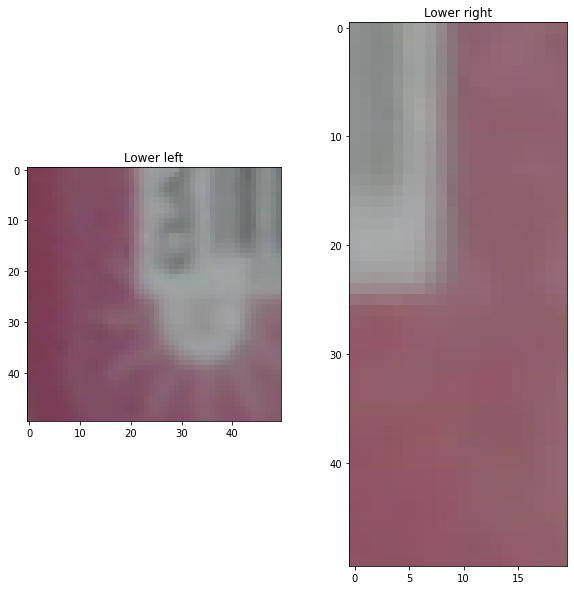

In [103]:
# Inspect the location of the bar code to calculate cm/pixel
plt.figure(figsize=(10,10))
plt.subplot(121); plt.imshow(result[750: 800, 0: 50]); plt.title('Lower left')
plt.subplot(122); plt.imshow(result[750: 800, 100:120]); plt.title('Lower right')

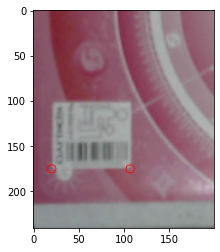

23.54022988505747

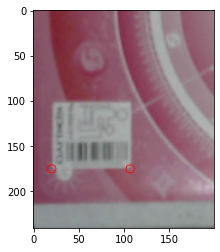

In [105]:
bar_code_lower_left = [20, 775]
bar_code_lower_right = [107, 775]
bar_code_width_in_cm = 3.2 # Manual measurement in cm
cm_per_pixel = bar_code_width_in_cm / abs(bar_code_lower_left[0] - bar_code_lower_right[0])

cv.circle(result, bar_code_lower_left, 5, [255,0,0])
cv.circle(result, bar_code_lower_right, 5, [255,0,0])
plt.imshow(result[600:, :200])

# Test with the width of the object
cm_per_pixel * result.shape[1]
cv.circle()

In [106]:
# Save matrix and cm/pixel ratio to perspective_matrix.yaml
data = {'perspective_matrix': np.asarray(perspective_matrix).tolist(), 'cm_per_pixel': np.asarray([cm_per_pixel]).tolist()}
with open("perspective_matrix.yaml", "w") as f:
    yaml.dump(data, f)